# De-noising the recording using STFT

The raw `wav` file of the recording has a significant amount of noise.

This noise could be identified by transforming the recording to the fourier domain, and obtaining frequencies of lower amplitude than a defined threshold.

These frequencies can then be removed, and an inverse fourier transform could be applied to re-obtain the sound, now de-noised.

Read in the `wav` file and list its attributes.

In [367]:
from scipy.io import wavfile
import numpy as np
import warnings

warnings.filterwarnings("ignore")

rate, data = wavfile.read('../recordings/001.wav')

# length of recording
time_duration = data.shape[0] / rate

print(rate)

print(f'Number of channels {data.shape[1]}; Time duration of recording {time_duration}')

44100
Number of channels 2; Time duration of recording 15.512312925170068


Since the recordings to be de-noised are from a guitar riff, it is a non-stationary signal. So, to analyze the frequency domain, we will use `stft` to analyze the frequency domain of short intervals instead.

We also want the number of segments of the `stft` to be NOLA (Non-zero OverLap Add). We need to do this so that we can perform `istft` to get back the `wav` file.

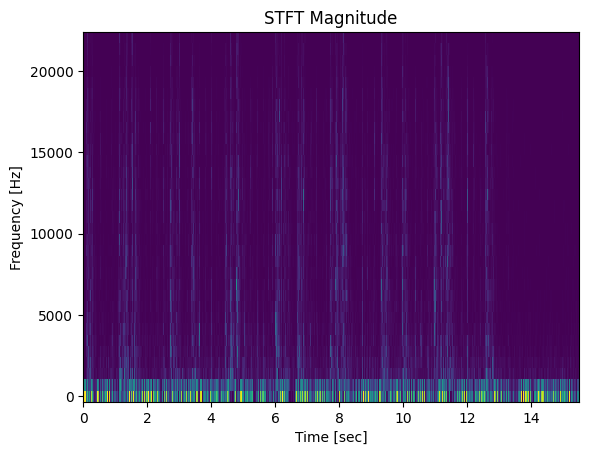

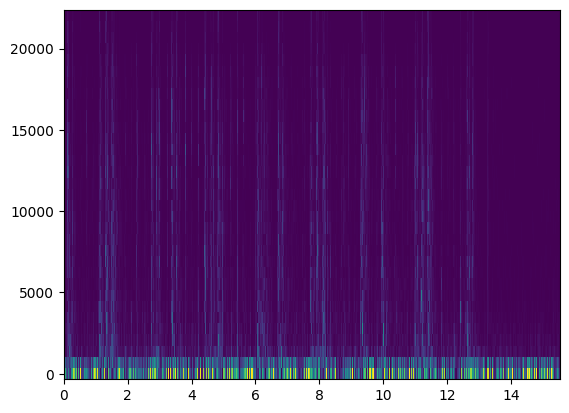

In [368]:
from scipy import signal
import matplotlib.pyplot as plt

nperseg = 64

# Check NOLA
# assert(((data.shape[0] - nperseg) % nperseg) == 0)

# Transpose to obtain both channels
channels = data.T

# Channel 1 stft
f_1, t_1, Zxx_1 = signal.stft(channels[0], rate, nperseg=nperseg)
plt.pcolormesh(t_1, f_1, np.abs(Zxx_1), shading='auto')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

# Channel 2 stft
f_2, t_2, Zxx_2 = signal.stft(channels[1], rate, nperseg=nperseg)
plt.pcolormesh(t_2, f_2, np.abs(Zxx_1), shading='auto')

Let us now de-noise the spectogram. We can do this by essentially choosing a threshold amplitude under which we deem the frequency bin to be noise. We choose the region of worth keeping frequencies as between 90 to 97th percentile. Why an upper-bound? Because it appears that STFT, due to overlaps in segments, appears to generate new noise artifacts throughout the recording. These artifacts happen to be quite loud. So finding a 'goldilocks' zone of the required frequencies is needed.

In [369]:
# Extract only magnitude
Zxx_1_abs = np.abs(Zxx_1)
Zxx_2_abs = np.abs(Zxx_2)

# Estimate the 'goldilocks' zone
upper_threshold = np.percentile(Zxx_1_abs, 97)
lower_threshold = np.percentile(Zxx_1_abs, 90)
print(upper_threshold)
print(lower_threshold)

9654.369667968713
1923.2728393554682


Apply the threshold on the spectogram channels.

In [370]:
Zxx_1 = np.where(np.logical_and(lower_threshold < Zxx_1_abs, Zxx_1_abs < upper_threshold), Zxx_1, 0)
# Since signal should be identical/close to identical in second channel, use same threshold
Zxx_2 = np.where(np.logical_and(lower_threshold < Zxx_2_abs, Zxx_2_abs < upper_threshold), Zxx_2, 0)

Now, we will attempt to generate a de-noised `wav` file from the spectograms. Apply `istft` to obtain re-constructed signal.

In [371]:
_, Zxx_1_reconstructed = signal.istft(Zxx_1, rate)
_, Zxx_2_reconstructed = signal.istft(Zxx_2, rate)

data_reconstructed = np.asarray([Zxx_1_reconstructed, Zxx_2_reconstructed], dtype=np.int16)

wavfile.write('../Output/output.wav', rate, data_reconstructed.T)

The de-noised file is in `Output/outut.wav`! The output is noticeably not very well 'de-noised' and introduces quite a number of artifacts. There are two aspects to look into.

* When converting to the fourier domain, we loose out on phase information. It is not just the frequencies, but also how these frequencies are in phase with each other that affects the final product, which we do not retain.
* The 'Goldilocks' zone approach does not cover all the cases of overlap induced artifacts and issues involving frequency and time resolution.